In [75]:
import os
current_directory = os.getcwd()
print(current_directory)

/Users/ucla/Notebooks


In [76]:
# Python Analysis for FINRA SIE User Success Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('userSuccess.csv')


In [77]:
# Convert date columns to datetime format
df['examDay'] = pd.to_datetime(df['examDay'])
df['createdAt'] = pd.to_datetime(df['createdAt'])

# Clean and standardize 'result' column
df['result'] = df['result'].astype(str).str.strip().str.capitalize()

# Feature engineering
df['prep_duration_days'] = (df['examDay'] - df['createdAt']).dt.days
df = df[df['prep_duration_days'] >= 0]  # Remove negative prep durations
df['signup_weekday'] = df['createdAt'].dt.day_name()
df['exam_weekday'] = df['examDay'].dt.day_name()
df['signup_month'] = df['createdAt'].dt.to_period('M')
df['exam_month'] = df['examDay'].dt.to_period('M')

# Reclassify results into binary: 'Pass' or 'Fail'
df['result_binary'] = df['result'].apply(lambda x: 'Pass' if x == 'Pass' or x == '70' else 'Fail')

# Define custom color palette
palette = {'Pass': '#7FC97F', 'Fail': '#F0027F'}  # Light green and reddish

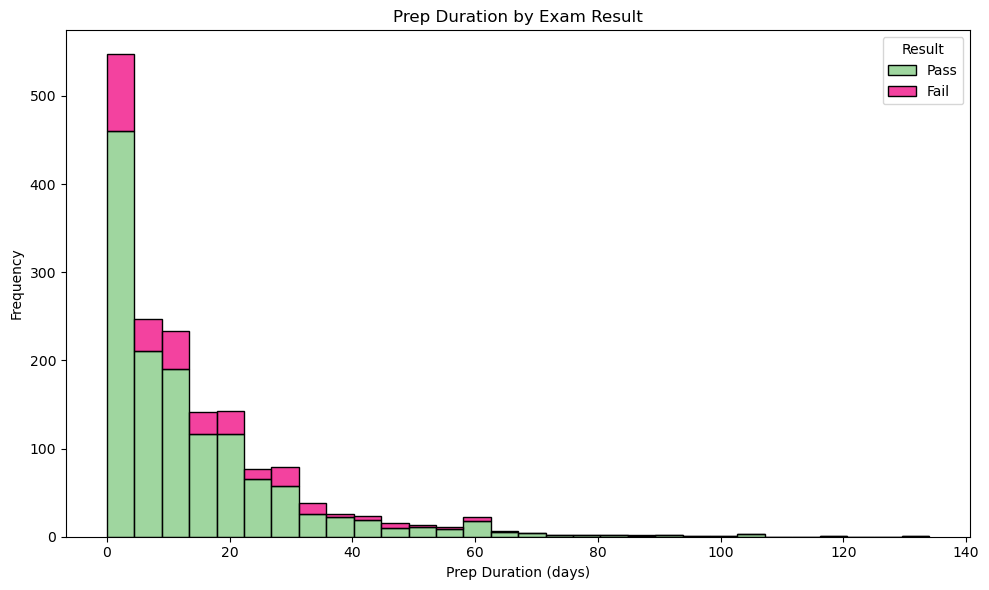

In [78]:
#1. Prep Duration by Exam Result

# Plot updated histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='prep_duration_days', hue='result_binary', bins=30, kde=False,
             multiple='stack', palette=palette)
plt.title('Prep Duration by Exam Result')
plt.xlabel('Prep Duration (days)')
plt.ylabel('Frequency')
plt.legend(title='Result', labels=['Pass', 'Fail'])
plt.tight_layout()
plt.show()

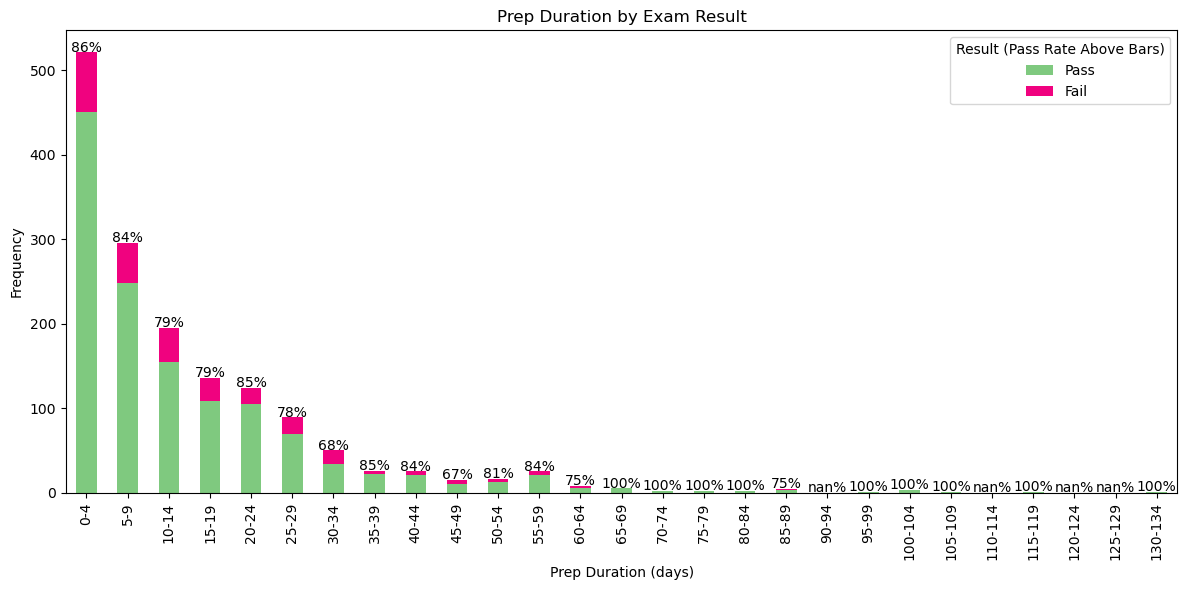

In [79]:
# Create histogram with stacked bars
bin_edges = range(0, df['prep_duration_days'].max() + 5, 5)
hist_data = pd.cut(df['prep_duration_days'], bins=bin_edges)
counts = df.groupby([hist_data, 'result_binary']).size().unstack(fill_value=0)
counts.index = [f'{interval.left}-{interval.right - 1}' for interval in counts.index]
counts['Total'] = counts.sum(axis=1)
counts['Pass Rate'] = counts['Pass'] / counts['Total']

# Plot
ax = counts[['Pass', 'Fail']].plot(kind='bar', stacked=True, color=[palette['Pass'], palette['Fail']], figsize=(12, 6))
plt.title('Prep Duration by Exam Result')
plt.xlabel('Prep Duration (days)')
plt.ylabel('Frequency')

# Annotate pass rate above each bar
for i, (total, pass_rate) in enumerate(zip(counts['Total'], counts['Pass Rate'])):
    plt.text(i, total + 1, f'{pass_rate:.0%}', ha='center')

# Update legend
handles, labels = ax.get_legend_handles_labels()
labels = ["Pass", "Fail"]
ax.legend(handles, labels, title="Result (Pass Rate Above Bars)")
plt.tight_layout()
plt.show()


In [80]:
#T-test: Prep Duration by Result (Conclusion: Insignificant)
duration_pass = df[df['result_binary'] == 'Pass']['prep_duration_days']
duration_fail = df[df['result_binary'] == 'Fail']['prep_duration_days']
t_stat, p_val = ttest_ind(duration_pass, duration_fail, nan_policy='omit')
print(f"T-test between pass and fail durations: t-stat={t_stat:.2f}, p-value={p_val:.4f}")
print("Conclusion: Insignificant")

T-test between pass and fail durations: t-stat=-0.99, p-value=0.3223
Conclusion: Insignificant


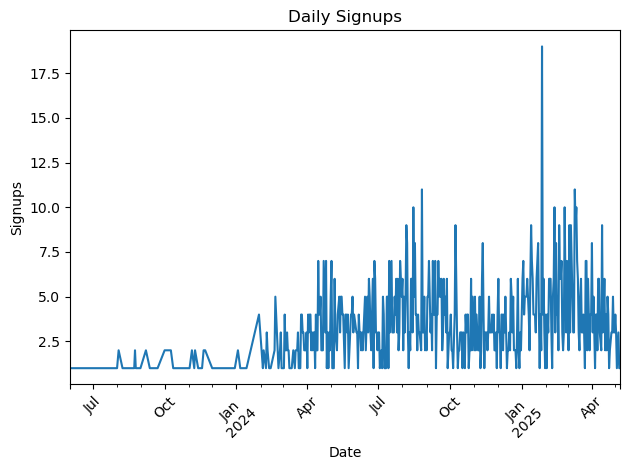

In [81]:
# 2. Time Series: Daily Signups
signup_trend = df['createdAt'].dt.to_period('D').value_counts().sort_index()
signup_trend.plot(kind='line', title='Daily Signups')
plt.ylabel('Signups')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

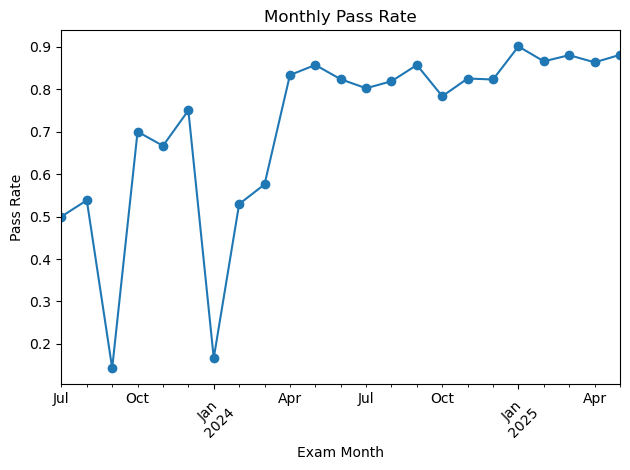

In [82]:
# 3. Time Series: Monthly Pass Rates
monthly_result_dist = df.groupby('exam_month')['result'].value_counts(normalize=True).unstack()
monthly_pass_rate = monthly_result_dist['Pass']
monthly_pass_rate.plot(marker='o', title='Monthly Pass Rate')
plt.ylabel('Pass Rate')
plt.xlabel('Exam Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

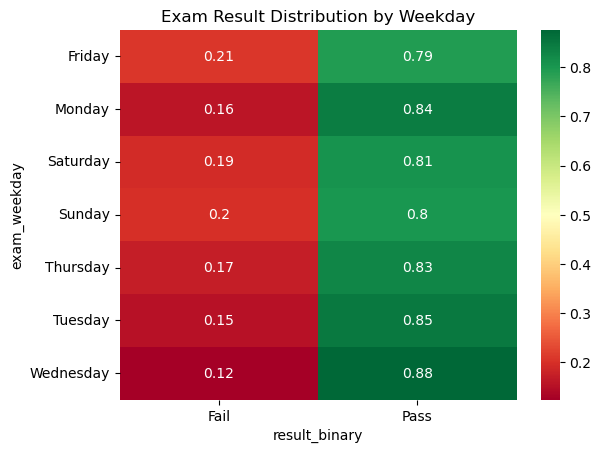

In [83]:
# 4. Heatmap: Exam Day of Week vs Result
weekday_result = pd.crosstab(df['exam_weekday'], df['result_binary'], normalize='index')
sns.heatmap(weekday_result, annot=True, cmap='RdYlGn')  # swapped to red-green
plt.title('Exam Result Distribution by Weekday')
plt.show()

In [84]:
# 6. Chi-square Test: Exam Weekday vs Result
chi2_data = pd.crosstab(df['exam_weekday'], df['result'])
chi2, p, _, _ = chi2_contingency(chi2_data)
print(f"Chi-square test of exam weekday vs result: chi2={chi2:.2f}, p-value={p:.4f}")

Chi-square test of exam weekday vs result: chi2=156.98, p-value=0.0680
